# Generative Adversarial Network

## Hyperparams

In [1]:
batch_size = 64
epochs = 1000
lr = 1e-04

## Dependecies

In [2]:
from sklearn.datasets import load_digits
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Sequential, Linear, LeakyReLU, Sigmoid
from torch.nn.functional import binary_cross_entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as th
import numpy as np

## Load dataset

In [3]:
#load dataset and create a batch
digits, targets = load_digits(return_X_y=True, n_class = 2)
digits /= 16
dataloader = DataLoader(list(zip(digits.astype("float32"), targets.astype("float32"))), batch_size= batch_size, shuffle= True, drop_last= True)

In [4]:
#np.savetxt("data/digits.csv", digits, delimiter=",")
#np.savetxt("data/labels.csv", targets, delimiter=",")

<Figure size 432x288 with 0 Axes>

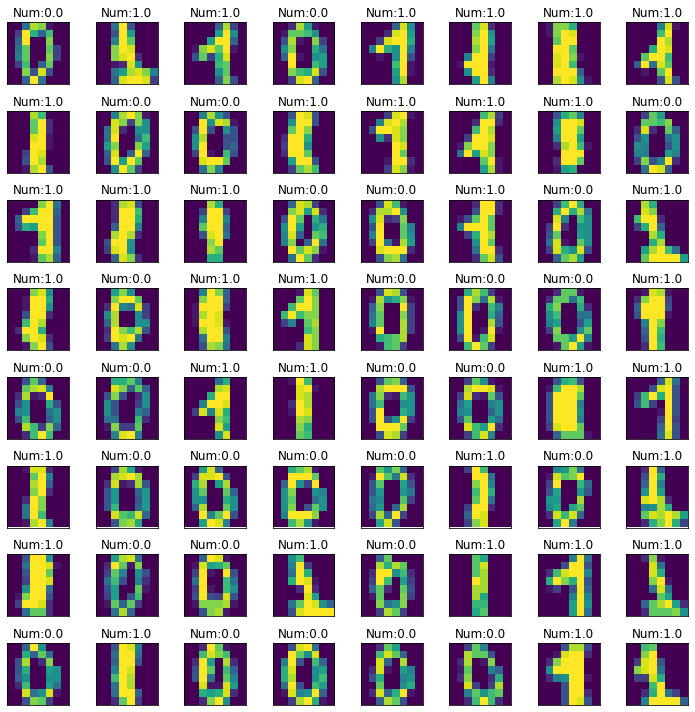

In [5]:
#show the first iteration batch
images, labels = next(iter(dataloader))
plt.figure()
f, axarr = plt.subplots(8,8, figsize=(10,10)) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(images[i].reshape(8,8))
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax.set_title(f"Num:{labels[i]}")
f.tight_layout()
plt.show()

## Create Generator

In [6]:
gen = Sequential(Linear(64,64),
                LeakyReLU(),
                Linear(64,64),
                Sigmoid())

In [7]:
#from pytorch_model_summary import summary

In [8]:
#print(summary(gen, th.zeros((1, 64)), show_input=True))

## Discriminator

In [9]:
disc = Sequential(Linear(64,64),
                LeakyReLU(),
                Linear(64,1),
                Sigmoid()
                )

disc(th.zeros((1, 64)))

tensor([[0.4954]], grad_fn=<SigmoidBackward0>)

In [10]:
#print(summary(disc, th.zeros((1, 64)), show_input=True))

## Training

In [11]:
d_opt = Adam(disc.parameters(), lr)
g_opt = Adam(gen.parameters(), lr)

In [12]:
ep_d_loss = []
ep_g_loss = []
with tqdm(range(epochs)) as t:
    for ep in t:
        for images, labels in dataloader:
            d_losses = []
            g_losses = []
            #===============================
            # Discriminator Network Training
            #===============================
            d_opt.zero_grad()
            real_preds = disc(images)
            real_targets = th.ones(images.size(0), 1)
            real_loss = binary_cross_entropy(real_preds, real_targets)
            
            # Generate fake images
            latent = th.randn(batch_size, 64)
            fake_images = gen(latent)

            # Pass fake images through discriminator
            fake_targets = th.zeros(fake_images.size(0), 1)
            fake_preds = disc(fake_images)
            fake_loss = binary_cross_entropy(fake_preds, fake_targets)

            # Update discriminator weights
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_opt.step()
            #===============================
            # Generator Network Training
            #===============================
            g_opt.zero_grad()
        
            # Generate fake images
            latent = th.randn(batch_size, 64)
            fake_images = gen(latent)
            
            # Try to fool the discriminator
            preds = disc(fake_images)
            targets = th.ones(batch_size, 1)
            g_loss = binary_cross_entropy(preds, targets)
            
            # Update generator weights
            g_loss.backward()
            g_opt.step()

            # Keep losses for logging
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        # Save average losses
        ep_d_loss.append(np.mean(d_losses))
        ep_g_loss.append(np.mean(g_losses))
        t.set_postfix({"Discriminator loss" : np.mean(d_losses), "Generator loss" : np.mean(g_losses)})
#         if ep % 200 == 0:
#             plt.figure()
#             f, axarr = plt.subplots(8,8) 
#             for i, ax in enumerate(axarr.ravel()):
#                 ax.imshow(gen(th.rand(64)).detach().numpy().reshape(8,8))
#                 ax.tick_params(left=False,
#                             bottom=False,
#                             labelleft=False,
#                             labelbottom=False)
#             f.tight_layout()
#             plt.show()
# plt.figure()
# f, axarr = plt.subplots(8,8) 
# for i, ax in enumerate(axarr.ravel()):
#     ax.imshow(gen(th.rand(64)).detach().numpy().reshape(8,8))
#     ax.tick_params(left=False,
#                 bottom=False,
#                 labelleft=False,
#                 labelbottom=False)
# f.tight_layout()
# plt.show()

100%|██████████| 1000/1000 [00:11<00:00, 83.34it/s, Discriminator loss=1.23, Generator loss=0.758]


<Figure size 432x288 with 0 Axes>

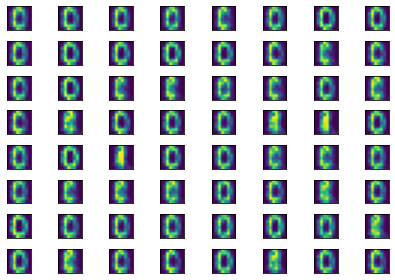

In [13]:
plt.figure()
f, axarr = plt.subplots(8,8) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(gen(th.rand(64)).detach().numpy().reshape(8,8))
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
f.tight_layout()
plt.show()

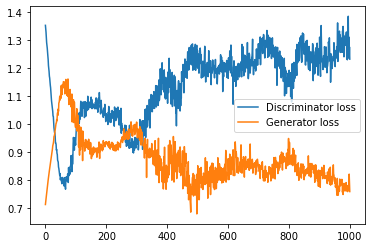

In [14]:
x = np.arange(1000)
plt.plot(x, ep_d_loss, label = "Discriminator loss")
plt.plot(x, ep_g_loss, label = "Generator loss")
plt.legend()
plt.show()